In [2]:
#mount drive, upload datasets, and import necessary packages
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! unzip '/content/drive/MyDrive/HAM10000_metadata_gc.zip'

Archive:  /content/drive/MyDrive/HAM10000_metadata_gc.zip
  inflating: HAM10000_metadata       


In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_images_part_1_gc'

In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_images_part_2_gc'

In [6]:
#import statements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

In [7]:
md = pd.read_csv("/content/HAM10000_metadata")
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [8]:
#load all datasets and examine them
#create numerical labels based on disease categories

In [9]:
lab_enc = LabelEncoder()
lab_enc.fit(md['dx'])
LabelEncoder()
print(list(lab_enc.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [10]:
md['label'] = lab_enc.transform(md["dx"]) 

In [11]:
#add image paths and image ndarrays to metadata set

In [12]:
fldr1 = '/content/HAM10000_images_part_1'
fldr2 = '/content/HAM10000_images_part_2'

im_paths = []

for i in md['image_id']:
  fid = i

  fn = '/' + fid + '.jpg'

  if os.path.isfile(fldr1 + fn) == True:
    im_paths.append(fldr1+fn)
  else:
    im_paths.append(fldr2+fn)

In [13]:
md['image_paths'] = im_paths
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_paths
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2,/content/HAM10000_images_part_2/ISIC_0031633.jpg
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033084.jpg
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033550.jpg
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033536.jpg
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0032854.jpg


In [14]:
#resize image
im_size = 224

In [15]:
md['image'] = md['image_paths'].map(lambda x: np.asarray(Image.open(x).resize((im_size,im_size))))
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_paths,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0027419.jpg,"[[[187, 150, 192], [190, 154, 195], [192, 156,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025030.jpg,"[[[24, 13, 22], [25, 13, 23], [24, 14, 23], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0026769.jpg,"[[[186, 127, 135], [188, 129, 137], [191, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025661.jpg,"[[[23, 11, 15], [24, 11, 18], [24, 10, 19], [2..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2,/content/HAM10000_images_part_2/ISIC_0031633.jpg,"[[[125, 83, 105], [132, 89, 112], [138, 93, 11..."
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033084.jpg,"[[[115, 92, 101], [108, 92, 96], [108, 91, 98]..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033550.jpg,"[[[4, 6, 3], [5, 6, 3], [6, 6, 5], [7, 8, 4], ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033536.jpg,"[[[105, 92, 96], [109, 102, 103], [118, 109, 1..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0032854.jpg,"[[[156, 115, 138], [158, 117, 138], [160, 121,..."


In [16]:
#create training and testing set
#standardize arrays by pixel values
#create labels arrays for output

In [17]:
train, test = train_test_split(md, test_size=0.25, random_state=29, shuffle=True)

In [18]:
trainX = np.array(train["image"].tolist())
trainX = trainX/225

trainY = train['label']
trainY_dx = to_categorical(trainY, num_classes=7)

In [19]:
testX = np.array(test["image"].tolist())
testX = testX/225

testY = test['label']
testY_dx = to_categorical(testY, num_classes=7)

In [20]:
#model creation: 3 convolutional layers with pooling layers and dropout layers, then two dense layers ending in softmax activation

In [21]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(im_size, im_size, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 256)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 256)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 128)       0

In [22]:
#hyperparameters and model fitting
batch_size = 16 
epochs = 75

In [23]:
mod_fit = model.fit(
    trainX, trainY_dx,
    epochs=epochs,
    batch_size = batch_size,
    verbose=2)

Epoch 1/75
470/470 - 23s - loss: 1.0635 - acc: 0.6689 - 23s/epoch - 48ms/step
Epoch 2/75
470/470 - 11s - loss: 0.9597 - acc: 0.6729 - 11s/epoch - 24ms/step
Epoch 3/75
470/470 - 11s - loss: 0.9053 - acc: 0.6867 - 11s/epoch - 24ms/step
Epoch 4/75
470/470 - 11s - loss: 0.8528 - acc: 0.7002 - 11s/epoch - 24ms/step
Epoch 5/75
470/470 - 11s - loss: 0.8023 - acc: 0.7188 - 11s/epoch - 24ms/step
Epoch 6/75
470/470 - 11s - loss: 0.7612 - acc: 0.7305 - 11s/epoch - 24ms/step
Epoch 7/75
470/470 - 11s - loss: 0.7171 - acc: 0.7472 - 11s/epoch - 24ms/step
Epoch 8/75
470/470 - 11s - loss: 0.6763 - acc: 0.7572 - 11s/epoch - 24ms/step
Epoch 9/75
470/470 - 11s - loss: 0.6478 - acc: 0.7702 - 11s/epoch - 24ms/step
Epoch 10/75
470/470 - 11s - loss: 0.5927 - acc: 0.7876 - 11s/epoch - 24ms/step
Epoch 11/75
470/470 - 11s - loss: 0.5790 - acc: 0.7918 - 11s/epoch - 24ms/step
Epoch 12/75
470/470 - 11s - loss: 0.5444 - acc: 0.8055 - 11s/epoch - 24ms/step
Epoch 13/75
470/470 - 11s - loss: 0.5224 - acc: 0.8111 - 11s/

In [24]:
#model accuracies, classwise accuracies, predictions

In [25]:
mod_acc = model.evaluate(testX, testY_dx)
print('Test Accuracy: ', mod_acc[1])

79/79 [==============================] - 2s 21ms/step - loss: 2.1285 - acc: 0.6701
Test Accuracy:  0.670127809047699


In [26]:
y_preds = model.predict(testX)

79/79 [==============================] - 2s 18ms/step


In [27]:
y_pred_classes = np.argmax(y_preds, axis=1)

In [28]:
y_true = np.argmax(testY_dx, axis=1)

In [29]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_classes, target_names = ['Akiec', 'Bcc', 'Bkl', 'Df', 'Mel', 'Nv', 'Vasc'])
print(report)

              precision    recall  f1-score   support

       Akiec       0.31      0.09      0.14        91
         Bcc       0.25      0.11      0.15       132
         Bkl       0.28      0.27      0.28       271
          Df       0.33      0.07      0.11        30
         Mel       0.36      0.32      0.34       277
          Nv       0.78      0.89      0.83      1669
        Vasc       0.50      0.21      0.29        34

    accuracy                           0.67      2504
   macro avg       0.40      0.28      0.31      2504
weighted avg       0.63      0.67      0.64      2504



In [30]:
def classwise_accuracy():
   a = pd.crosstab(y_true,y_pred_classes)
   print(a.max(axis=1)/a.sum(axis=1))
classwise_accuracy()

row_0
0    0.373626
1    0.401515
2    0.538745
3    0.366667
4    0.537906
5    0.889754
6    0.441176
dtype: float64


In [31]:
#confusion matrix and percent misclassified by disease categories

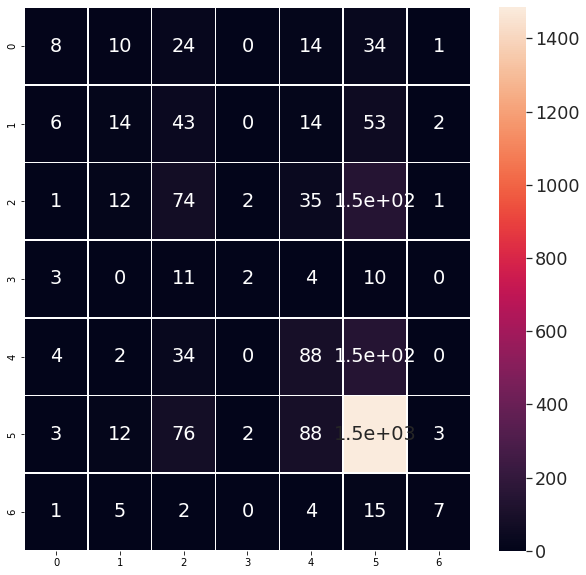

In [32]:
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [33]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

incorr_fraction = incorr_fraction.tolist()

incorr_fraction = [round(item, 2) for item in incorr_fraction]

incorr_fraction

[0.91, 0.89, 0.73, 0.93, 0.68, 0.11, 0.79]

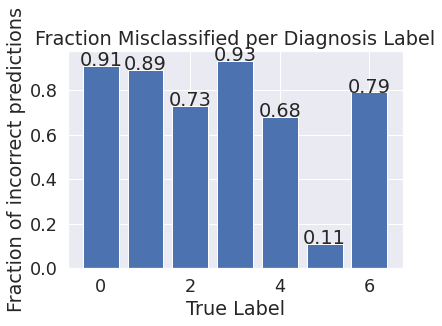

In [34]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
  
if __name__ == '__main__':
  plt.bar(np.arange(7), incorr_fraction)
  addlabels(np.arange(7), incorr_fraction)
  plt.title("Fraction Misclassified per Diagnosis Label")
  plt.xlabel('True Label')
  plt.ylabel('Fraction of incorrect predictions')